# DSC 80: Lab 05

### Due Date: Tuesday May 4, Midnight (11:59 PM)

## Instructions
Much like in DSC 10, this Jupyter Notebook contains the statements of the problems and provides code and markdown cells to display your answers to the problems. Unlike DSC 10, the notebook is *only* for displaying a readable version of your final answers. The coding work will be developed in an accompanying `lab*.py` file, that will be imported into the current notebook.

Labs and programming assignments will be graded in (at most) two ways:
1. The functions and classes in the accompanying python file will be tested (a la DSC 20),
2. The notebook will be graded (for graphs and free response questions).

**Do not change the function names in the `*.py` file**
- The functions in the `*.py` file are how your assignment is graded, and they are graded by their name. The dictionary at the end of the file (`GRADED FUNCTIONS`) contains the "grading list". The final function in the file allows your doctests to check that all the necessary functions exist.
- If you changed something you weren't supposed to, just use git to revert!

**Tips for working in the Notebook**:
- The notebooks serve to present you the questions and give you a place to present your results for later review.
- The notebook on *lab assignments* are not graded (only the `.py` file).
- Notebooks for PAs will serve as a final report for the assignment, and contain conclusions and answers to open ended questions that are graded.
- The notebook serves as a nice environment for 'pre-development' and experimentation before designing your function in your `.py` file.

**Tips for developing in the .py file**:
- Do not change the function names in the starter code; grading is done using these function names.
- Do not change the docstrings in the functions. These are there to tell you if your work is on the right track!
- You are encouraged to write your own additional functions to solve the lab! 
    - Developing in python usually consists of larger files, with many short functions.
    - You may write your other functions in an additional `.py` file that you import in `lab**.py` (much like we do in the notebook).
- Always document your code!

### Importing code from `lab**.py`

* We import our `.py` file that's contained in the same directory as this notebook.
* We use the `autoreload` notebook extension to make changes to our `lab**.py` file immediately available in our notebook. Without this extension, we would need to restart the notebook kernel to see any changes to `lab**.py` in the notebook.
    - `autoreload` is necessary because, upon import, `lab**.py` is compiled to bytecode (in the directory `__pycache__`). Subsequent imports of `lab**` merely import the existing compiled python.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lab05 as lab

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


import requests
import bs4

## Payment data

**Question 1**

You are given a dataset that describes payment information for purchases made on 01-Jan-2019 contianing the columns: `Id`, `credit_card_type`, `credit_card_number`, and the purchaser's `date_of_birth`.

You need to assess the  missingness in payments data. In particular, **Is the credit card number missing at random dependent on the age of shopper?** Look at distribution of ages by missingness of `credit_card_number` and determine if the missingness is dependent on age or not.

`Hint`: use the following steps to approach this problem:

* Obtain the ages of the purchasers
* Plot the distribution of ages by missingness (density curves).
    
* Do you think the missingness of credit card number is dependent on age or not?

Perform a permutation test for the empirical distribution of age conditional on `credit_card_number` with a 5% significance level. Use difference of means as your statistic.

Write a function `first_round` with no arguments that returns a __list__ with two values:
* the first value is the p-value from your permutation test and 
* the second value is either "R" if you reject the null hypothesis, or "NR" if you do not.

**Does the result match your guess? If no, what might be a problem?**

Perform another permutation test for the empirical distribution of age conditional on `credit_card_number` with a 5% significance level. Use KS-Statistic as your statistic.

Write a function `second_round` with no arguments that returns a __list__ with three values: 
* the first value is the p-value from your new permutation test 
* the second value is either "R" if you reject the null hypothesis or "NR" if you do not, and 
* the third value is your final conclusion: "D" (dependent on age) or "ND" (not dependent on age).



In [4]:
payment_fp = os.path.join('data', 'payment.csv')
payments = pd.read_csv(payment_fp)

In [5]:
payments['ages'] = np.floor((pd.to_datetime(
    '01-Jan-2019') - pd.to_datetime(payments['date_of_birth'])) / np.timedelta64(1, 'Y'))

In [6]:
payments['cc_num_is_null'] = payments.credit_card_number.isnull()

In [7]:
payments.credit_card_number.isnull().mean()

0.143

In [8]:
emp_dist = (
    payments
    .pivot_table(index='ages', columns='cc_num_is_null', values=None, aggfunc='size')
    .fillna(0)
    .apply(lambda x: x/x.sum())
)
emp_dist#.plot(title="distribution of ages by cc_num=missing/not missing")

cc_num_is_null,False,True
ages,,
13.0,0.004458,0.057377
14.0,0.005944,0.016393
15.0,0.011887,0.040984
16.0,0.007429,0.016393
17.0,0.005944,0.040984
...,...,...
82.0,0.013373,0.024590
83.0,0.016345,0.008197
84.0,0.014859,0.000000


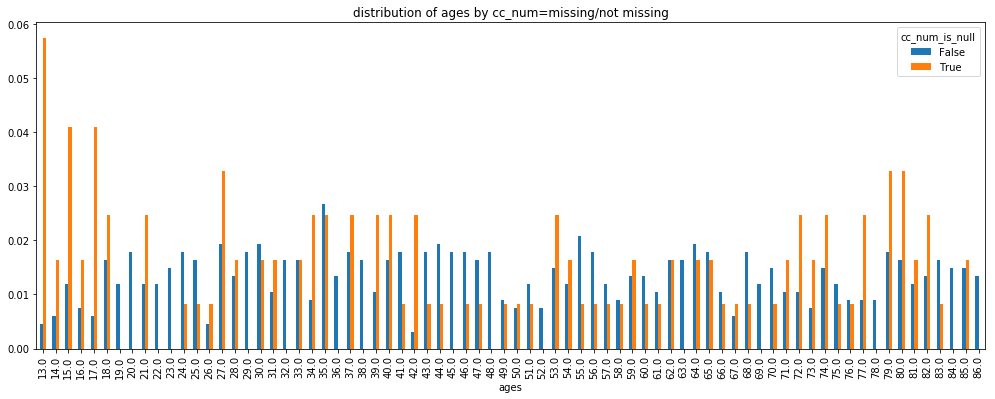

In [9]:
emp_dist.plot(kind='bar', title="distribution of ages by cc_num=missing/not missing", figsize=(17,6))

In [10]:
obs_mean_diff = payments.pivot_table(index='cc_num_is_null', values=None, aggfunc='mean')['ages'].diff().iloc[-1]
obs_mean_diff

-2.9451806201739217

In [11]:
n_repetitions = 500

payments_ages = payments.copy()[['ages', 'cc_num_is_null']]
mean_diffs = []

for _ in range(n_repetitions):
    shuffled_ages = (
        payments_ages['ages']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    shuffled = (
        payments_ages
        .assign(**{'Shuffled_ages': shuffled_ages})
    )
    mean_diff = (
        shuffled
        .pivot_table(index='cc_num_is_null', values=None, aggfunc='mean')['Shuffled_ages']
        .diff()
        .iloc[-1]
    )
    mean_diffs.append(mean_diff)

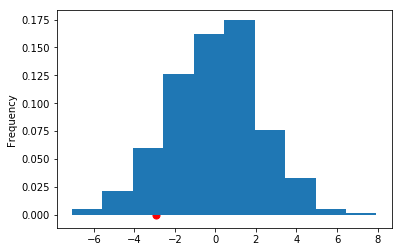

In [12]:
pd.Series(mean_diffs).plot(kind='hist', density=True)
plt.scatter(obs_mean_diff, 0, color='red', s=50)

In [13]:
p_value = np.count_nonzero(mean_diffs <= obs_mean_diff) / len(mean_diffs)
p_value #Fail to reject null

0.098

In [14]:
obs_ks = stats.ks_2samp(
    payments.groupby('cc_num_is_null')['ages'].get_group(True),
    payments.groupby('cc_num_is_null')['ages'].get_group(False)
).statistic
obs_ks

0.12699202780883062

In [15]:
n_repetitions = 500

payments_ages = payments.copy()[['ages', 'cc_num_is_null']]
kss = []

for _ in range(n_repetitions):
    shuffled_ages = (
        payments_ages['ages']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    shuffled = (
        payments_ages
        .assign(**{'Shuffled_ages': shuffled_ages})
    )
    ks = stats.ks_2samp(
                        shuffled.groupby('cc_num_is_null')['Shuffled_ages'].get_group(True),
                        shuffled.groupby('cc_num_is_null')['Shuffled_ages'].get_group(False)
                        ).statistic
    
    kss.append(ks)

0.028

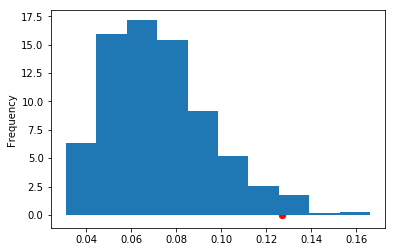

In [16]:
pval = np.mean(np.array(kss) > obs_ks)
pd.Series(kss).plot(kind='hist', density=True)
plt.scatter(obs_ks, 0, color='red', s=40)
pval

### Missingness and the proportion of null values

**Question 2**

In the file `data/missing_heights.csv` are the heights of children and their fathers (`child` and `father`). The `child_X` columns are missing values in varying proportions. The missingness of these `child_X` columns were created as MAR dependent on father height. The missingness of these `child_X` columns are all equally dependent on father height and each column `child_X` is `X%` non-null (verify this yourself!).

* You will attempt to *verify* the missingness of `child_X` on the `father` height column using permutation test. Your permutation tests should use `N=100` simulations and use the `KS` test statistic. Write a function `verify_child` that takes in the `heights` data and returns a __series__ of p-values (from your permutation tests), indexed by the columns `child_X`. 

* Now interpret your results. In the function `missing_data_amounts`, return a __list__ of correct statements from the options below:
    1. The p-value for `child_50` is small because the *sampling distribution* of test-statistics has low variance.
    1. MAR is hardest to determine when there are very different proportions of null and non-null values.
    1. The difference between p-value for `child_5` and `child_95` is due to randomness.
    1. You would always expect the p-value of `child_X` and `child_(100-X)` to be similar.
    1. You would only expect the p-value of `child_X` and `child_(100-X)` to be similar if the columns are MCAR.


In [58]:
fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(fp)

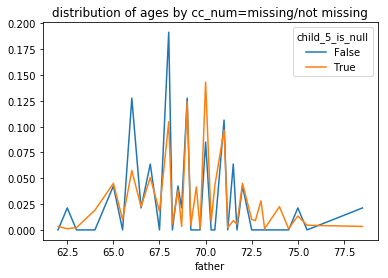

In [46]:
heights['child_5_is_null'] = heights.child_5.isnull()
emp_dist = (
    heights
    .pivot_table(index='father', columns='child_5_is_null', values=None, aggfunc='size')
    .fillna(0)
    .apply(lambda x: x/x.sum())
)
emp_dist.plot(title="distribution of ages by cc_num=missing/not missing")

In [59]:
heights.notnull().mean()

child       1.000000
father      1.000000
child_95    0.949679
child_90    0.900428
child_75    0.749465
child_50    0.500000
child_25    0.250535
child_10    0.099572
child_5     0.050321
dtype: float64

In [60]:
lab.verify_child(heights)

child_95    0.756
child_90    0.792
child_75    0.366
child_50    0.000
child_25    0.116
child_10    0.146
child_5     0.128
dtype: float64

### Imputation of Heights: quantitative columns

**Question 3**

In lecture, you learned how to do single-valued imputation conditionally on a *categorical* column: impute with the mean for each group. That is, for each distinct value of the *categorical* column, there is a single imputed value.

Here, you will do a single-valued imputation conditionally on a *quantitative* column. To do this, transform the `father` column into a categorical column by binning the values of `father` into [quartiles](https://en.wikipedia.org/wiki/Quartile). Once this is done, you can impute the column as in lecture (and described above).

* Write a function `cond_single_imputation` that takes in a dataframe with columns `father` and `child` (with missing values in `child`) and imputes single-valued mean imputation of the `child` column, conditional on `father`. Your function should return a __Series__ (Hint: `pd.qcut` may be helpful!).

*Hint:* The groupby method `.transform` is useful for this question (see discussion 3), though it's also possible using `aggregate`. As a reminder, *loops are not allowed*, and functions mentioned in "Hints" are not required.



In [626]:
new_heights = heights[['father', 'child_50']].rename(columns={'child_50': 'child'}).copy()

In [627]:
lab.cond_single_imputation(new_heights)

0      68.083871
1      68.083871
2      69.000000
3      69.000000
4      73.500000
         ...    
929    64.000000
930    62.000000
931    65.481383
932    66.500000
933    65.481383
Name: child, Length: 934, dtype: float64

### Probabilistic imputation of quantitative columns

**Question 4**

In lecture, you learned how to impute a categorical column by sampling from the dataframe column. One problem with this technique is that the imputation will never generate imputed values that weren't already in the dataset. When the column under consideration is quantitative, this may not be a reasonable assumption. For example, `56.0`, `57.0`, and `57.5` are in the heights dataset, yet `56.5` is not. Thus, any imputation done by sampling from the dataset will not be able to generate a height of `56.5`, even though it's clearly a reasonable value to occur in the dataset.

To keep things simple, you will impute the `child` column *unconditionally* from the distribution of `child` heights present in the dataset. This means that you will use the values present in `child` to impute missing values. i.e. values that appear in `child` more will probably appear more when imputing.

The approach to imputing from a quantitative distribution, is as follows:
* Find the empirical distribution of `child` heights by creating a histogram (using 10 bins) of `child` heights.
* Use this histogram to generate a number within the observed range of `child` heights:
    - The likelihood a generated number belongs to a given bin is the proportion of the bin in the histogram. (Hint: `np.histogram` is useful for this part).
    - Any number within a fixed bin is equally likely to occur. (Hint: `np.random.choice` and `np.random.uniform` may be useful for this part).
    
Create a function `quantitative_distribution` that takes in a Series and an integer `N > 0`, and returns an array of `N` using the method described above. (For writing this function, and this function only, it is *ok* to use loops).

Create a function `impute_height_quant` that takes in a Series of `child` heights with missing values (aka `child_X`) and imputes them using the scheme above. **You should use `quantitative_distribution` to help you do this.**

In [630]:
lab.impute_height_quant(new_heights['child']).mean()

66.7134903640256

# I'm ready for scraping! But am I allowed to?

**Question 5**

We know that many sites have a published policy allowing or disallowing automatic access to their site. Often, this policy is in a text file `robots.txt`. There is (`https://moz.com/learn/seo/robotstxt`) a good article that explains what these files are, where to find them, and how to use them. After reading the article please answer a few questions. 

**2.1: What is the purpose of `robots.txt`?**

1) To informs agents which pages to crawl.

2) To informs agents that the site is automated.

3) To inform agents that robots will chase them down if their info is stolen.

**2.2: Where do you put your `robots.txt` file?**

1) In the folder you want to disallow.

2) In the root directory of your website.

3) In a Google search.


**2.3: If a `robots.txt` is not present, does it mean you can legally scrape the site?**

1) Yes

2) No

**2.4: Each subdomain on a root domain can use separate `robots.txt` file**

1) Yes

2) No


**2.5: Website hunt**

Next, find three websites that explicitly use a `robots.txt` file and allow scraping (by everyone) and three that do not allow generic user-agents to scrape it (denoted by `*`).

* Note: Some websites may cause gradescope to time out. Please change a website if you encounter this issue. 




Now combine you answers to multiple choice questions in one list and urls of the sites you found in another list. 
Create an argument-free function `answers` to return both of lists.


## Congratulations! You're done!

* Submit the lab on Gradescope